# Cointegration Experiment
This is a proof of concept for selecting pairs of stocks that are cointegrated. Note that this requires an API key, so follow the instructions in the README to get one.
**This notebook relies on the scripts in the src folder.**

In [30]:
import os
import sys
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime, timedelta
from datetime import time
from src.util import (
    save_dataframe,
    load_dataframe,
    plot_price_data,
    plt_show,
    eastern,
    BarUtils,
)
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import seaborn as sns
from itertools import combinations
from tqdm import tqdm

load_dotenv()

ALPACA_API_KEY = os.getenv("ALPACA_API_KEY")
ALPACA_API_SECRET = os.getenv("ALPACA_API_SECRET")
DATA_DIR = "data"

Define the tickers and timeframes.

In [31]:
utility_tickers = [
    "NEE", "EXC", "D", "PCG", "XEL", 
    "ED", "WEC", "DTE", "PPL", "AEE", 
    "CNP", "FE", "CMS", "EIX", "ETR", 
    "EVRG", "LNT", "PNW", "IDA", "AEP", 
    "DUK", "SRE", "ATO", "NRG",
]
refresh_bars = False # set to true to refresh the bars. this requires the alpaca api key and secret to be set in the .env file
start_date = datetime(2023, 1, 1)
end_date = datetime.today() - timedelta(minutes=15)
timeframe = TimeFrame.Hour

Load the data.

Loading data/utility_close_prices.pkl


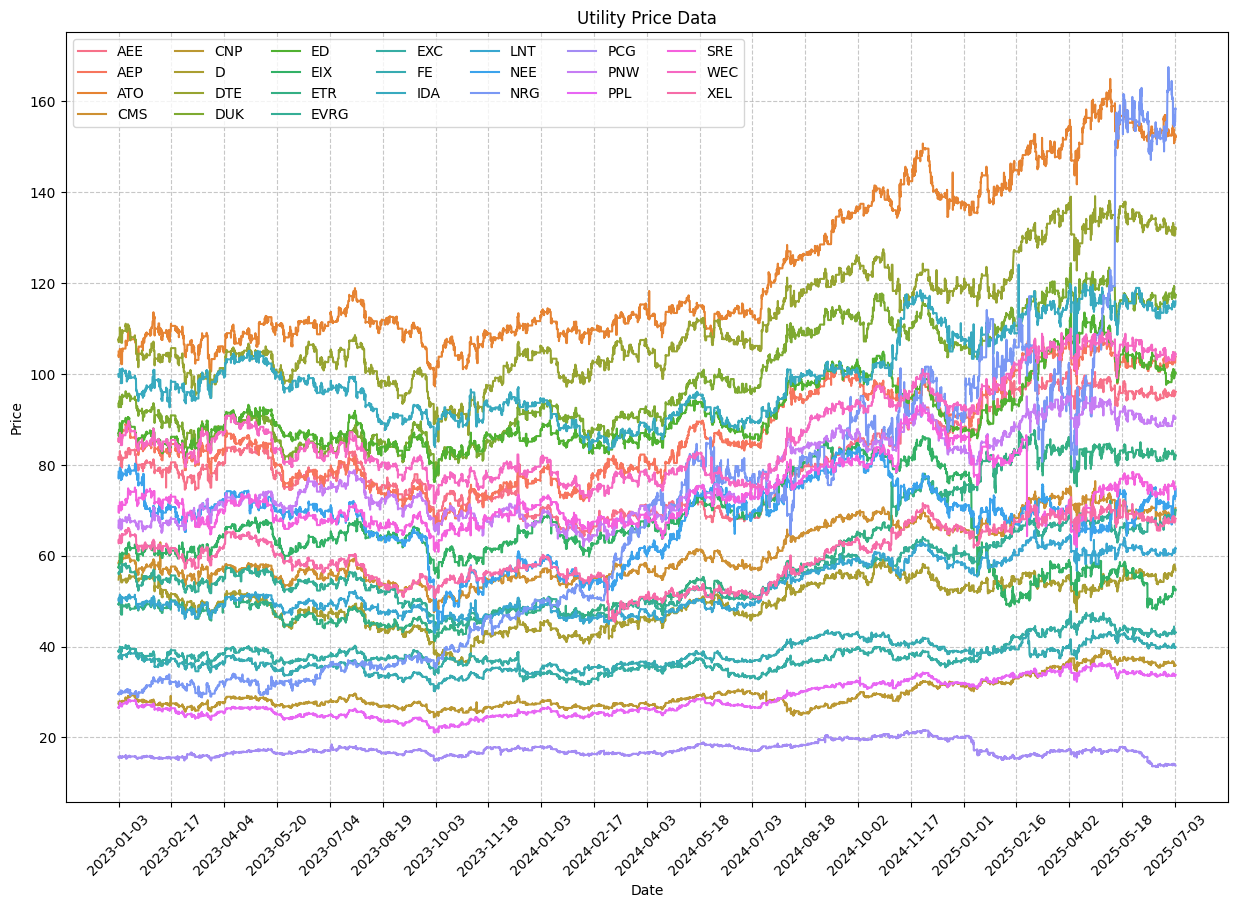

In [32]:
client = StockHistoricalDataClient(
    api_key=ALPACA_API_KEY, secret_key=ALPACA_API_SECRET
)
request_params = StockBarsRequest(
    symbol_or_symbols=utility_tickers,
    timeframe=timeframe,
    start=start_date,
    end=end_date,
    adjustment="all",
)

if refresh_bars:
    bars = client.get_stock_bars(request_params).df  # get the bars
    save_dataframe(bars, "utility_bars")  # save the bars
    bars = load_dataframe("utility_bars")  # load the bars
    # convert all the dates to est. this is a multi-index dataframe, so we need to convert the index
    bars.index = bars.index.map(lambda x: (x[0], x[1].astimezone(eastern)))
    # resample the bars. apply to each ticker
    bars = BarUtils.resample_multi_ticker_bars(bars)
    save_dataframe(bars, "utility_bars_resampled")
    # get the close prices
    close_prices = bars["close"].unstack(level=0)
    save_dataframe(close_prices, "utility_close_prices")

# load them from the data directory
close_prices = load_dataframe("utility_close_prices", DATA_DIR)
plot_price_data(close_prices, "Utility Price Data")
plt_show(prefix="utility_price_data")


## Analyze the relationship between prices
For selection, we take the spread (price difference) over all combinations of two tickers. In order for a pairs trading strategy to work, the prices in a pair must be cointegrated. We use the Johansen test for that.

In [33]:
tt_split = 0.8 # 80% of the data is used for training

# we want the strategy to train on
train_prices = close_prices.iloc[:int(tt_split * len(close_prices))]
test_prices = close_prices.iloc[int(tt_split * len(close_prices)):]
print(f"Train prices: {train_prices.shape}")
print(f"Test prices: {test_prices.shape}")

Train prices: (17513, 24)
Test prices: (4379, 24)


Engle Granger test

276it [00:01, 156.71it/s]


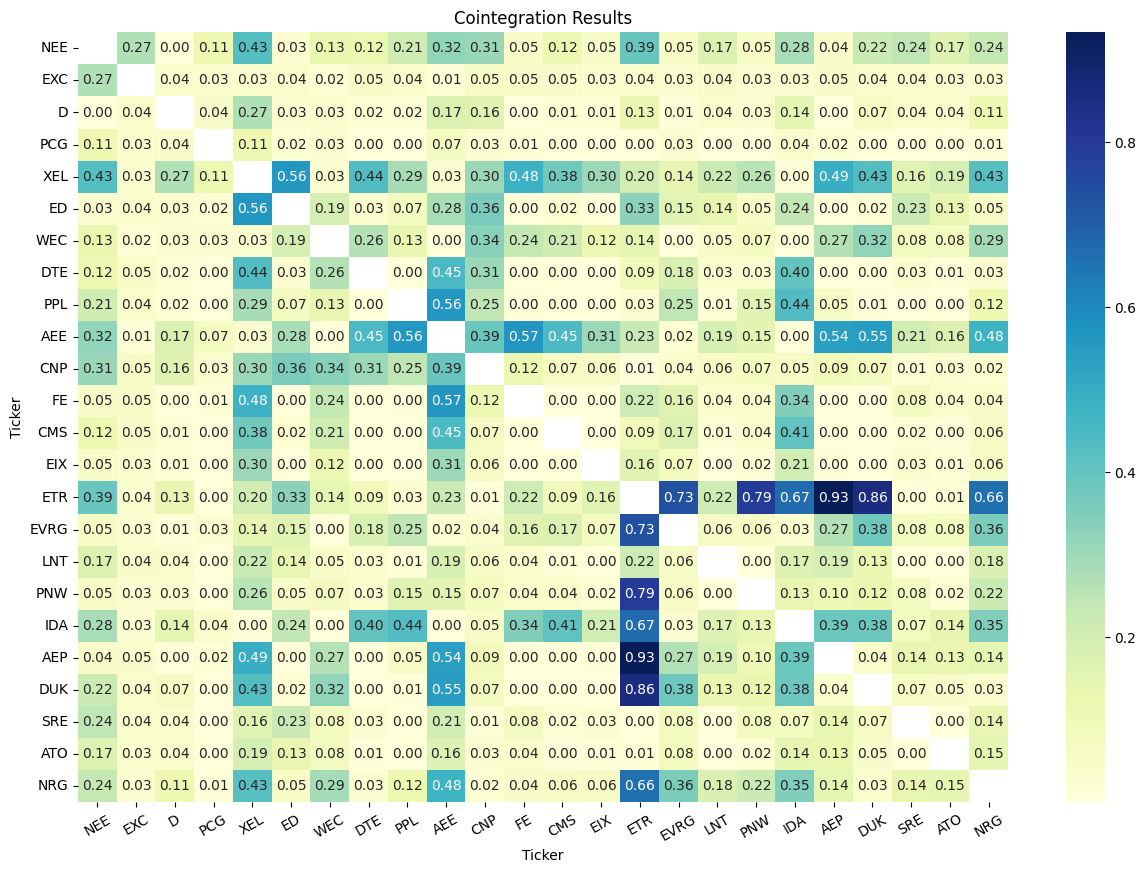

In [34]:
cointegration_results = pd.DataFrame(
    index=utility_tickers, columns=utility_tickers)
for primary, secondary in tqdm(combinations(utility_tickers, 2)):
    # model with linear regression
    results = sm.OLS(train_prices[primary],
                   sm.add_constant(train_prices[secondary])).fit()
    alpha = results.params.iloc[0]
    beta = results.params.iloc[1]

    # calculate the residuals
    residuals = train_prices[primary] - beta * train_prices[secondary] - alpha

    # calculate the adf test statistic
    adf_stat = adfuller(residuals, maxlag=1)
    test_stat, p_value, lags_used, nobs, critical_values = adf_stat[:5]
    critical_values = pd.Series(
        critical_values.values(), index=critical_values.keys(), name="Critical Values")

    #if p_value < 0.05:
    #    print(f"{primary}-{secondary} (alpha: {alpha}, beta: {beta})")
    #    print(f"- ADF Statistic: {test_stat}, P-Value: {p_value}")
    #    print(f"- Critical Values:\n{critical_values}\n")

    # store the results
    cointegration_results.loc[primary, secondary] = p_value
    cointegration_results.loc[secondary, primary] = p_value

# show the cointegration results as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(
    cointegration_results.values.astype(np.double),
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
)
plt.grid(False)
plt.title("Cointegration Results")
plt.xlabel("Ticker")
plt.ylabel("Ticker")
plt.xticks(np.arange(len(utility_tickers)) + 0.5, utility_tickers, rotation=30)
plt.yticks(np.arange(len(utility_tickers)) + 0.5, utility_tickers, rotation=0)
plt_show(prefix="cointegration_results")

Sort pairs by results and take the lowest 10 values. 

In [ ]:
# sort
best_pairs = cointegration_results.stack().sort_values(ascending=True)

# create a list of dicts with the pair and p-value and remove duplicates
best_pairs = best_pairs.to_dict()
best_pairs = list(set([tuple(sorted(pair)) for pair in best_pairs.keys()])) # remove duplicates
best_pairs = best_pairs[:10]
best_pairs

[('CMS', 'LNT'),
 ('AEE', 'PPL'),
 ('DUK', 'PCG'),
 ('AEP', 'DTE'),
 ('ATO', 'PNW'),
 ('PPL', 'SRE'),
 ('ETR', 'XEL'),
 ('DTE', 'ETR'),
 ('CMS', 'PCG'),
 ('ATO', 'ETR')]

We use a rolling beta to determine spread pricing
https://github.com/quantrocket-codeload/quant-finance-lectures/blob/master/quant_finance_lectures/Lecture42-Introduction-to-Pairs-Trading.ipynb